In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/rafael.goncalves/Documents/personal/cnn/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/valid'

#classes to be used
classes = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
           'olympic wrestling', 'rugby', 'canoe slalom', 'roller derby', 'high jump',
           'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
           'rings', 'swimming', 'uneven bars', 'figure skating pairs']

Num GPUs Available:  0


In [3]:
import math

def load_data(data_dir, batch_size, img_size):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    data_flow = datagen.flow_from_directory(
        data_dir,
        class_mode="categorical",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        classes=classes
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: data_flow,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *img_size, 3], [None, len(classes)])
    )

    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE), math.ceil(data_flow.samples / batch_size)

In [4]:
img_size = (180, 180)
batch_size = 64

train_dataset, steps_per_epoch = load_data(train_dir, batch_size=batch_size, img_size=img_size)
val_dataset, validation_steps = load_data(val_dir, batch_size=batch_size, img_size=img_size)
test_dataset, test_steps = load_data(test_dir, batch_size=batch_size, img_size=img_size)

Found 3147 images belonging to 20 classes.
Found 95 images belonging to 20 classes.
Found 95 images belonging to 20 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    elif epoch < 25:
        return lr * 0.85
    else:
        return lr * 0.75


lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_efficientnet_it_01.keras',
    monitor='val_loss',
    save_best_only=True
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 447ms/step - accuracy: 0.3145 - loss: 2.3139 - val_accuracy: 0.7579 - val_loss: 0.8184 - learning_rate: 5.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.7044 - loss: 0.9503 - val_accuracy: 0.8421 - val_loss: 0.4855 - learning_rate: 5.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 451ms/step - accuracy: 0.7606 - loss: 0.7645 - val_accuracy: 0.8632 - val_loss: 0.4050 - learning_rate: 5.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.8029 - loss: 0.6412 - val_accuracy: 0.8842 - val_loss: 0.3719 - learning_rate: 5.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.8124 - loss: 0.5740 - val_accuracy: 0.9368 - val_loss: 0.2820 - learning_rate: 5.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - accuracy: 0.8261 - loss: 0.5492 - val_accuracy: 0.8842 - val_loss: 0.3316 - learning_rate: 5.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 450ms/step - acc

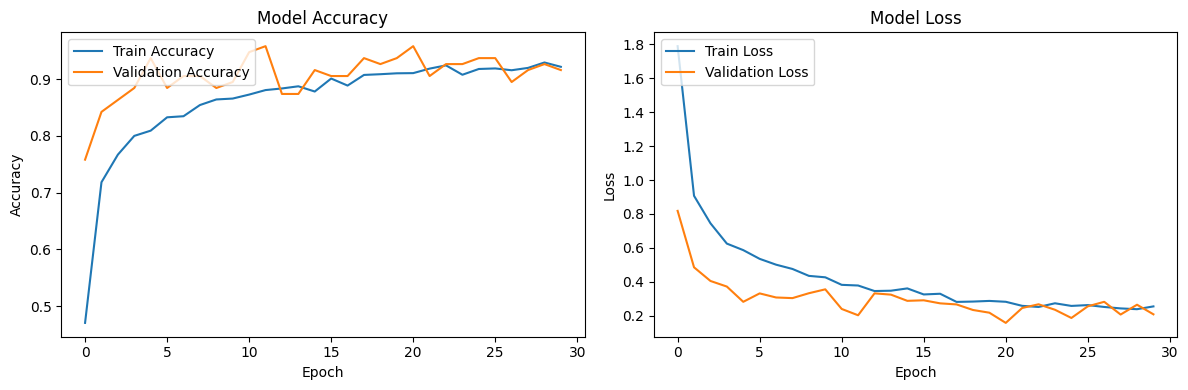

In [7]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [8]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")
model.save('final_model_efficientnet_it_01.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9126 - loss: 0.2232
Test accuracy: 91.58%
Test loss: 0.2182
